In [1]:
# checking for GPU availability
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Evaluation
This notebook provides the code to run evaluation on the Inference Model.

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from itertools import cycle
from PIL import Image
import numpy as np
import pandas as pd
import pickle
import os
import copy

np.random.seed(1)

In [3]:
EPSILON = 1e-5
# Load mtsd testing images
CLASSES = ['Speed limit','Pass either side','Obstruction', 'Roadway diverges', 'Bumps']
#Path to the mtsd test dataset
DATASET_PATH = './mtsd_data/mtsd_test_images/'
test_set = [f for f in os.listdir(DATASET_PATH) if f.lower().endswith('.jpg')]

print("Test set size:", len(test_set))

Test set size: 100


In [4]:
category_index = {1: {'id': 1, 'name': 'Speed limit'},
 2: {'id': 2, 'name': 'Pass either side'},
 3: {'id': 3, 'name': 'Obstruction'},
 4: {'id': 4, 'name': 'Roadway diverges'},
 5: {'id': 5, 'name': 'Bumps'}}
categories = [{'id': 1, 'name': 'Speed limit'},
 {'id': 2, 'name': 'Pass either side'},
 {'id': 3, 'name': 'Obstruction'},
 {'id': 4, 'name': 'Roadway diverges'},
 {'id': 5, 'name': 'Bumps'}]

## Load detection results

In [5]:
MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/exported_model' ## Change this to the model you want to evaluate

MODEL_PATH = os.path.join('models', MODEL_NAME)
with open(os.path.join(MODEL_PATH, 'detections_output_result.pkl'), 'rb') as pickle_file:
    detections = pickle.load(pickle_file)

In [6]:
# Checking keys and gt_bbox for the detections
for file_path, det in detections.items():
    print(f"File: {file_path}, Keys: {list(det.keys())}")
    print(f"pred_bboxes: {det['pred_bboxes']}")
    print(f"pred_classes: {det['pred_classes']}")
    print(f"confidences: {det['confidences']}")
    print(f"gt_bboxes: {det['gt_bboxes']}")
    print(f"gt_classes: {det['gt_classes']}")
    break

File: 001008_png_jpg.rf.33afa4c0dfa3dc065d645d5975aee302.jpg, Keys: ['pred_bboxes', 'pred_classes', 'confidences', 'gt_bboxes', 'gt_classes']
pred_bboxes: [[[0.5000643730163574, 0.5582485198974609, 0.6865543127059937, 0.8298553228378296], [0.2755870819091797, 0.6021509170532227, 0.44603049755096436, 0.8268647193908691], [0.4867629408836365, 0.5671870708465576, 0.691667377948761, 0.8296953439712524], [0.25669771432876587, 0.5951071381568909, 0.42537522315979004, 0.8398624062538147], [0.4955034852027893, 0.6065896153450012, 0.6495341658592224, 0.8123298287391663], [0.47326719760894775, 0.5545991063117981, 0.6216335296630859, 0.7989581227302551], [0.26986023783683777, 0.6150528788566589, 0.40127578377723694, 0.8021218180656433], [0.4867629408836365, 0.5671870708465576, 0.691667377948761, 0.8296953439712524], [0.7414575219154358, 0.618901252746582, 0.8971766829490662, 0.8468953371047974], [0.5067708492279053, 0.5740278363227844, 0.6684620380401611, 0.7588977217674255], [0.22929880023002625

## Helper codes

In [7]:
def get_detection_by_filename(detections, filename):
    if filename not in detections:
        print(f"Warning: {filename} not found in detections.")
        return {'pred_bboxes': [[]], 'pred_classes': [[]], 'confidences': [[]], 'gt_bboxes': [], 'gt_classes': []}

    detection = detections[filename]

    return detection 

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def plot_rectangle(ax, filename, bbox, class_name, edgecolor, confidence=None):
    """
    Draws a rectangle for ground truth (gt) or predicted (pd) bounding boxes on the given axis.
    
    Args:
        ax (matplotlib axis): Axis to plot the rectangle.
        filename (str): The image filename.
        bbox (list): Bounding box coordinates [xmin, ymin, xmax, ymax].
        class_name (str): Class name of the object.
        edgecolor (str): Color of the bounding box.
        confidence (float, optional): Confidence score for predicted boxes.
        box_type (str, optional): Either 'gt' (ground truth) or 'pd' (predicted).
    """
    xmin, ymin, xmax, ymax = bbox
    
    # Load image to get width & height
    image = cv2.imread(os.path.join(DATASET_PATH, filename))
    height, width, _ = image.shape  # Corrected order (H, W, C)

    # Scale bbox coordinates from [0,1] to pixel values
    left = int(xmin * width)
    right = int(xmax * width)
    top = int(ymin * height)
    bot = int(ymax * height)
    
    # Draw bounding box
    ax.add_patch(
        plt.Rectangle((left, top),
                      right - left,
                      bot - top, fill=False,
                      edgecolor=edgecolor, linewidth=1.5)
    )

    # Define label format
    label = f"{class_name}"
    if confidence is not None:
        label += f': {confidence:.2f}%'

    label_pos_x = left
    label_pos_y = top - 5  # Adjusted label position

    # Draw label text
    ax.text(label_pos_x, label_pos_y, label,
            bbox=dict(facecolor=edgecolor, edgecolor=edgecolor, alpha=0.8),
            fontsize=8, color='black')

In [9]:
# Color mapping for each class
CLASSES_COLOR = ['DarkOrange', 'Aqua', 'Chartreuse', 'Magenta', 'Yellow']

def plot_dets(detection, filename):
    """
    Plots ground truth (GT) and predicted bounding boxes (PD) side by side.

    Args:
        detection: Dictionary containing 'pred_bboxes', 'pred_classes', 'confidences', 'gt_bboxes', 'gt_classes'.
        filename: The image filename to construct full path.
    """
    file_path = os.path.join(DATASET_PATH, filename)

    # Ensure file exists before opening
    if not os.path.exists(file_path):
        print(f"Warning: File {file_path} not found!")
        return

    # Load image
    image = np.array(Image.open(file_path).convert('RGB'))

    # Create two side-by-side plots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display image in both subplots
    ax[0].imshow(image, aspect='equal')
    ax[1].imshow(image, aspect='equal')

    # Titles
    ax[0].set_title("Ground Truth Bounding Boxes")
    ax[1].set_title("Predicted Bounding Boxes")

    # Draw ground truth bounding boxes (left plot)
    gt_bboxes = detection.get('gt_bboxes', [])
    gt_classes = detection.get('gt_classes', [])

    if not gt_bboxes or not gt_classes:
        print(f"Warning: No ground truth bounding boxes found for {filename}")

    for j in range(len(gt_bboxes)):
        gt_bbox = gt_bboxes[j]
        gt_class = gt_classes[j]

        if isinstance(gt_class, int):
            gt_class_id = gt_class
        else:
            gt_class_id = next((c['id'] for c in categories if c['name'].strip().lower() == gt_class.strip().lower()), None)

        if gt_class_id is None:
            print(f"Warning: Ground truth class '{gt_class}' not found in categories!")
            continue

        gt_color = CLASSES_COLOR[gt_class_id - 1] if gt_class_id else 'black'
        plot_rectangle(ax[0], filename, gt_bbox, category_index[gt_class_id]['name'], gt_color, None)

    # Draw predicted bounding boxes (right plot)
    pred_bboxes = detection.get('pred_bboxes', [])
    pred_classes = detection.get('pred_classes', [])
    confidences = detection.get('confidences', [])

    if not pred_bboxes or not pred_classes or not confidences:
        print(f"Warning: No predicted detections found for {filename}")

    # Flatten nested lists if necessary
    if isinstance(pred_classes[0], list):
        pred_classes = pred_classes[0] 

    for j in range(len(pred_bboxes)):
        pred_class = pred_classes[j]
        bbox = pred_bboxes[j]
        confidence = confidences[j] * 100  # Convert to percentage

        if pred_class not in category_index:
            print(f"Warning: Class ID {pred_class} not found in category_index!")
            continue

        plot_rectangle(ax[1], filename, bbox, category_index[pred_class]['name'], CLASSES_COLOR[pred_class-1], confidence)

    # Remove axes
    for a in ax:
        a.axis('off')

    plt.show()

In [10]:
def intersection(bbgt, bb):
    # determine the (x, y)-coordinates of the intersection rectangle
    ixmin = max(bbgt[0], bb[0])
    iymin = max(bbgt[1], bb[1])
    ixmax = min(bbgt[2], bb[2])
    iymax = min(bbgt[3], bb[3])
    
    # compute the area of intersection rectangle
    iw = max(ixmax - ixmin, 0)
    ih = max(iymax - iymin, 0)
    intersArea = iw * ih
    
    return intersArea

In [11]:
def union(bbgt, bb, intersArea):
    # compute the area of both the prediction and ground-truth rectangles
    boxgtArea = (bbgt[2] - bbgt[0]) * (bbgt[3] - bbgt[1])
    boxArea = (bb[2] - bb[0]) * (bb[3] - bb[1])
    unionArea = boxgtArea + boxArea - intersArea
    return unionArea

In [12]:
# Returns the intersection over union of two rectangles, a and b, where each is an array [x,y,w,h]
def compute_iou(bbgt, bb):
    overlaps = np.zeros(len(bbgt))
    for i,gtBbox in enumerate(bbgt):
        inters = float(intersection(gtBbox, bb))
        uni = union(gtBbox, bb, inters)
        iou = inters/uni
        overlaps[i] = iou
    ioumax = np.max(overlaps)
    jmax = np.argmax(overlaps)
    return ioumax, jmax

In [13]:
def naive_ap_calculation(rec,prec):
    """
    Take sum of P(k) * \Delta recall(k)
    """
    deltaRecall = []
    rec = np.insert(rec,0,0)
    for i in range(1,rec.shape[0]):
        deltaRecall.append( rec[i] - rec[i-1] ) # find differences
    deltaRecall = np.array(deltaRecall)
    ap = np.dot( deltaRecall,prec)
    return ap

In [14]:
def voc_ap(rec, prec, use_07_metric=False):
    """ ap = voc_ap(rec, prec, [use_07_metric])
    Compute VOC AP given precision and recall.
    If use_07_metric is true, uses the
    VOC 07 11 point method (default:False).
    """
    if use_07_metric:
        # 11 point metric
        # http://host.robots.ox.ac.uk/pascal/VOC/pubs/everingham10.pdf (page 313)
        
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        # correct AP calculation (from VOC 2010 challenge)
        # http://host.robots.ox.ac.uk/pascal/VOC/voc2012/devkit_doc.pdf (page 12)
        
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [15]:
def match_gts_and_compute_prec_recall_ap(cls, detections, iouthresh=0.5):
    """
    Computes precision, recall, and AP for a given class.

    Args:
        cls: Numeric class ID.
        detections: Dictionary {filename: {pred_bboxes, pred_classes, confidences, gt_bboxes, gt_classes}}.
        iouthresh: IoU threshold for a positive match.

    Returns:
        rec: Recall values.
        prec: Precision values.
        ap: Average precision.
    """
    print('IoU threshold set to: {:.2f}'.format(iouthresh))
    
    GT_OBJECTS = {}  # Stores ground truth bboxes per image
    BB = []  # Predicted bounding boxes
    BB_im_ids = []  # Image IDs for predicted bboxes
    BB_confidences = []  # Confidence scores
    n_gt_bboxes = 0  # Total ground truth bboxes
    
    for file_path, d in detections.items():
        BBGT = []
        
        # Convert gt_classes (names) to numeric IDs
        gt_class_ids = [category_index[cls]['id'] for cls in d['gt_classes'] if cls in category_index]

        for i in range(len(d['gt_bboxes'])):
            if gt_class_ids[i] == cls:
                BBGT.append(d['gt_bboxes'][i])
                n_gt_bboxes += 1
        
        GT_OBJECTS[file_path] = {
            'bboxes': np.asarray(BBGT),
            'detected?': [False] * len(BBGT)
        }

        for i in range(len(d['pred_bboxes'])):
            if d['pred_classes'][i] == cls:
                BB.append(d['pred_bboxes'][i])
                BB_im_ids.append(file_path)
                BB_confidences.append(d['confidences'][i])

    if n_gt_bboxes == 0:
        return None, None, None

    BB = np.asarray(BB)
    BB_confidences = np.asarray(BB_confidences)

    # Sort predictions by confidence
    if len(BB) > 0:
        sorted_ind = np.argsort(-BB_confidences)
        BB = BB[sorted_ind, :]
        BB_im_ids = [BB_im_ids[x] for x in sorted_ind]

    num_detections = len(BB_im_ids)
    tp = np.zeros(num_detections)
    fp = np.zeros(num_detections)
    avg_overlap = []

    for d in range(num_detections):
        gt_info = GT_OBJECTS[BB_im_ids[d]]
        bb = BB[d, :].astype(float)
        BBGT = gt_info['bboxes'].astype(float)

        ioumax = -np.inf
        if BBGT.size > 0:
            ioumax, jmax = compute_iou(BBGT, bb)

        if ioumax > iouthresh:
            if not gt_info['detected?'][jmax]:
                tp[d] = 1  # True positive
                gt_info['detected?'][jmax] = 1
                avg_overlap.append(ioumax)
            else:
                fp[d] = 1  # False positive (multiple detections)
        else:
            fp[d] = 1  # False positive

    avg_overlap = np.array(avg_overlap) if len(avg_overlap) > 0 else np.array([0])
    fp = np.cumsum(fp)
    tp = np.cumsum(tp)
    
    fn = n_gt_bboxes - tp[-1]
    rec = tp / np.maximum(tp + fn, np.finfo(np.float64).eps)
    prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    ap = voc_ap(rec, prec)

    class_name = category_index[cls]['name']
    print(f"TP: {tp[-1]} | FP: {fp[-1]} | FN: {fn}")
    print(f"Avg. overlap for {class_name} = {np.mean(avg_overlap):.4f}")
    print(f"Precision for {class_name} = {prec[-1]:.4f}")
    print(f"Recall for {class_name} = {rec[-1]:.4f}")

    return rec, prec, ap

In [16]:
def plot_precision_recall(prec, recall, ap):
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [recall[-1]]))
    mpre = np.concatenate(([prec[0]], prec, [0.]))
    # Plot Precision-Recall curve
    plt.clf()
    plt.plot(mrec, mpre, lw=2, color='navy',
             label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall: AP={0:0.2f}'.format(ap))
    plt.legend(loc="lower left")
    plt.show()

In [17]:
def plot_full_precision_recall(data):
    fig, ax = plt.subplots(figsize=(10, 12))
    lines = ["-","--","-.",":"]
    linecycler = cycle(lines)
    for d in data:
        recall = d['recall']
        prec = d['precision']
        ap = d['ap']
        cls = d['class']
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], recall, [recall[-1]]))
        mpre = np.concatenate(([prec[0]], prec, [0.]))
        ax.plot(mrec, mpre, next(linecycler), label='{} (AP = {:.2f}%)'.format(cls,ap*100))
        
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc="lower left")
    plt.draw()
    plt.tight_layout()
    plt.title("Full Precision-Recall Curves for all classes")
    plt.show()
    plt.clf()

In [18]:
# Function to convert class names to numerical IDs
def get_class_id(class_name):
    for category in categories:
        if category['name'] == class_name:
            return category['id']
    return None

def compute_mean_average_precision(detections):
    """
    Compute the Mean Average Precision (mAP) for object detection evaluation.

    INPUTS:
    - detections: dictionary {filename: {pred_bboxes, pred_classes, confidences, gt_bboxes, gt_classes}}
    
    OUTPUTS:
    - mAP: float
    """
    
    results = []
    plot_data = []
    aps = []

    # Convert ground truth class names to numeric IDs directly in `detections`
    for filename, data in detections.items():
        # Convert gt_classes (names) to numeric IDs
        gt_class_ids = [get_class_id(c) for c in data['gt_classes'] if get_class_id(c) is not None]
        detections[filename]['gt_classes'] = gt_class_ids

    # Compute precision-recall for each category
    for category in categories:
        class_id = category['id']
        class_name = category['name']

        print(f"Evaluation for {class_name}, (ID: {class_id}):")

        rec, prec, ap = match_gts_and_compute_prec_recall_ap(class_id, detections, iouthresh=0.5)

        if rec is None:
            print(f"No detections found for {class_name}. Skipping...")
            continue

        results.append({'class': class_name, 'precision': prec[-1], 'recall': rec[-1], 'ap': ap})
        plot_data.append({'class': class_name, 'precision': prec, 'recall': rec, 'ap': ap})

        if ap is not None:
            aps.append(ap)
            print(f'AP for {class_name} = {ap:.4f}')

        # Ensure `plot_precision_recall()` is defined before calling
        if 'plot_precision_recall' in globals():
            plot_precision_recall(prec, rec, ap)
        else:
            print("Warning: plot_precision_recall function is not defined. Skipping visualization.")

    # Compute Mean Average Precision (mAP)
    if aps:
        mAP = np.mean(aps)
        print(f'Mean AP = {mAP:.4f}')
    else:
        mAP = 0.0
        print("No AP values computed.")

    print('~~~~~~~~')
    print('Results:')
    
    df = pd.DataFrame.from_records(results, columns=('class', 'precision', 'recall', 'ap'))
    print(df)
    
    # Ensure `plot_full_precision_recall()` is defined before calling
    if 'plot_full_precision_recall' in globals():
        plot_full_precision_recall(plot_data)
    else:
        print("Warning: plot_full_precision_recall function is not defined. Skipping visualization.")
    
    return mAP

## Filter detections

In [19]:
import tensorflow as tf
import numpy as np

def apply_nms(detection, iou_threshold=0.5):
    """
    Applies Non-Maximum Suppression (NMS) to remove redundant overlapping detections.

    Args:
        detection (dict): A dictionary containing 'pred_bboxes', 'pred_classes', and 'confidences'.
        iou_threshold (float): IoU threshold for NMS.

    Returns:
        dict: Filtered detections after applying NMS.
    """
    if not detection['pred_bboxes'] or len(detection['pred_bboxes']) == 0:
        return detection

    # onvert to NumPy arrays
    bboxes = np.array(detection['pred_bboxes'])
    scores = np.array(detection['confidences'])
    classes = np.array(detection['pred_classes'])

    # Fix rank 3 issue by reshaping (remove extra dimension)
    if len(bboxes.shape) == 3 and bboxes.shape[0] == 1:
        bboxes = bboxes[0]  # Remove the extra dimension
    if len(scores.shape) == 2 and scores.shape[0] == 1:
        scores = scores[0]  # Flatten to 1D
    if len(classes.shape) == 2 and classes.shape[0] == 1:
        classes = classes[0]  # Flatten to 1D

    if bboxes.shape[0] == 0 or scores.shape[0] == 0:  # Check if there are no valid boxes
        return detection

    if bboxes.shape[1] != 4:  # Ensure boxes are in [num_boxes, 4] format
        print(f"Error: Bounding boxes have wrong shape {bboxes.shape}. Skipping NMS.")
        return detection

    # Apply NMS using TensorFlow
    selected_indices = tf.image.non_max_suppression(
        boxes=bboxes,
        scores=scores,
        max_output_size=20,  # Keep top 20 detections
        iou_threshold=iou_threshold,
        score_threshold=0.4  # Minimum confidence
    )

    selected_indices = selected_indices.numpy()  # Convert Tensor to NumPy

    # Keep only the selected boxes
    detection['pred_bboxes'] = [bboxes[i].tolist() for i in selected_indices]  
    detection['pred_classes'] = [classes[i] for i in selected_indices]
    detection['confidences'] = [scores[i] for i in selected_indices]

    return detection

# Apply NMS to all detections
for filename, detection in detections.items():
    detections[filename] = apply_nms(detection)

print("Applied Non-Maximum Suppression (NMS).")

Applied Non-Maximum Suppression (NMS).


In [20]:
# checking the bounding boxes format to ensure both are in the same format
for filename, detection in detections.items():
    print(f"Filename: {filename}")
    print(f"Ground Truth BBoxes: {detection.get('gt_bboxes', 'No GT')}")
    print(f"Predicted BBoxes: {detection['pred_bboxes']}")

Filename: 001008_png_jpg.rf.33afa4c0dfa3dc065d645d5975aee302.jpg
Ground Truth BBoxes: [[186, 158, 266, 216]]
Predicted BBoxes: [[0.5000643730163574, 0.5582485198974609, 0.6865543127059937, 0.8298553228378296]]
Filename: 007_0032_png.rf.f20b2a569d3089b910bd6aa8861aac45.jpg
Ground Truth BBoxes: [[7, 0, 312, 320]]
Predicted BBoxes: [[0.024912029504776, 0.010844618082046509, 0.9829486608505249, 0.9648721218109131]]
Filename: 05_PNG_jpg.rf.cb1b134e10149ce6bbbc915080e9d624.jpg
Ground Truth BBoxes: [[70, 2, 274, 267]]
Predicted BBoxes: [[0.0, 0.25998055934906006, 0.8341232538223267, 0.8205996751785278]]
Filename: 07_PNG.rf.252f2513a4b26003901cc4bf4ba09f0d.jpg
Ground Truth BBoxes: [[23, 0, 320, 320]]
Predicted BBoxes: [[0.007828950881958008, 0.08665955066680908, 1.0, 0.9968655109405518]]
Filename: 0_00006_00019-ppm_jpg.rf.4c6ef28a27bfe504b4a8c51758fd3560.jpg
Ground Truth BBoxes: [[5, 0, 304, 305]]
Predicted BBoxes: [[0.07148945331573486, 0.045979052782058716, 0.9269319176673889, 0.958615303039

In [21]:
# Since both gt and pred boxes are not in the same format, 
# we reformat the gt boxes by normalizing them with the original image size
# Normalize GT bboxes to [0,1]
image_width, image_height = 320, 320
for filename, data in detections.items():
    data['gt_bboxes'] = [[x / image_width, y / image_height, w / image_width, h / image_height] for x, y, w, h in data['gt_bboxes']]

Evaluation for Speed limit, (ID: 1):
IoU threshold set to: 0.50
TP: 10.0 | FP: 7.0 | FN: 10.0
Avg. overlap for Speed limit = 0.9020
Precision for Speed limit = 0.5882
Recall for Speed limit = 0.5000
AP for Speed limit = 0.5000


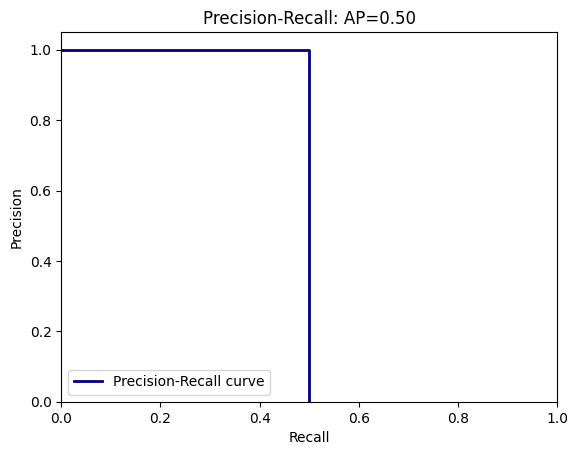

Evaluation for Pass either side, (ID: 2):
IoU threshold set to: 0.50
TP: 13.0 | FP: 5.0 | FN: 7.0
Avg. overlap for Pass either side = 0.7184
Precision for Pass either side = 0.7222
Recall for Pass either side = 0.6500
AP for Pass either side = 0.5642


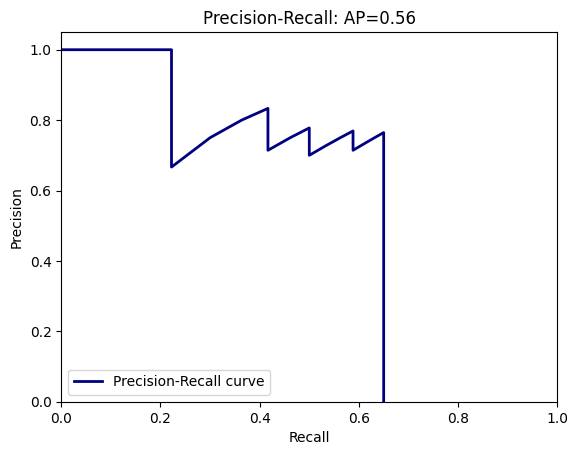

Evaluation for Obstruction, (ID: 3):
IoU threshold set to: 0.50
TP: 14.0 | FP: 3.0 | FN: 6.0
Avg. overlap for Obstruction = 0.8596
Precision for Obstruction = 0.8235
Recall for Obstruction = 0.7000
AP for Obstruction = 0.6834


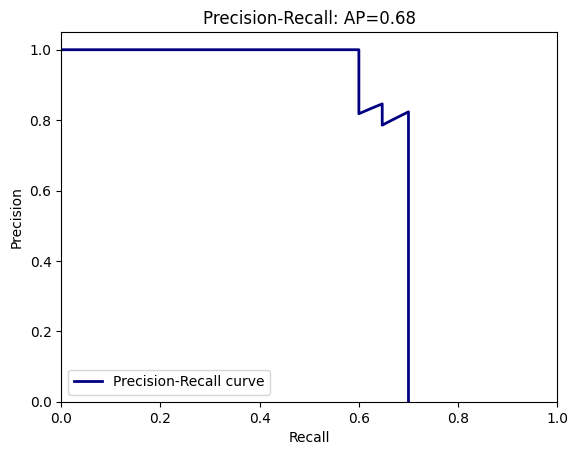

Evaluation for Roadway diverges, (ID: 4):
IoU threshold set to: 0.50
TP: 12.0 | FP: 4.0 | FN: 8.0
Avg. overlap for Roadway diverges = 0.8591
Precision for Roadway diverges = 0.7500
Recall for Roadway diverges = 0.6000
AP for Roadway diverges = 0.5806


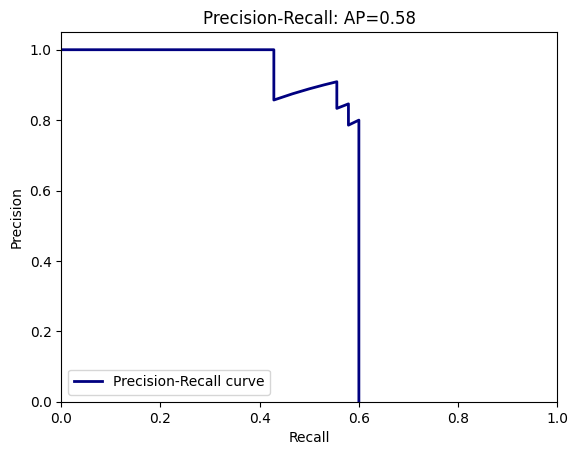

Evaluation for Bumps, (ID: 5):
IoU threshold set to: 0.50
TP: 14.0 | FP: 4.0 | FN: 6.0
Avg. overlap for Bumps = 0.8370
Precision for Bumps = 0.7778
Recall for Bumps = 0.7000
AP for Bumps = 0.6978


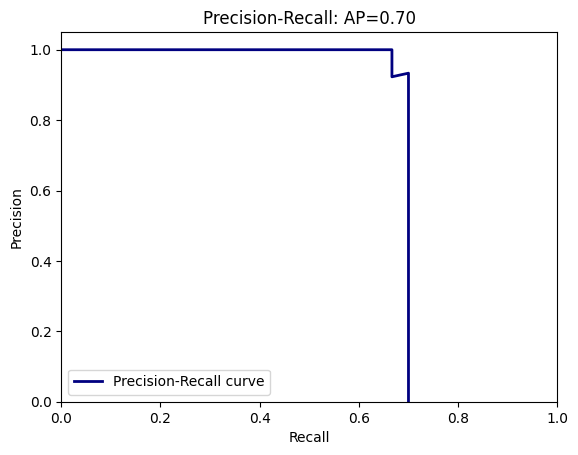

Mean AP = 0.6052
~~~~~~~~
Results:
              class  precision  recall        ap
0       Speed limit   0.588235    0.50  0.500000
1  Pass either side   0.722222    0.65  0.564179
2       Obstruction   0.823529    0.70  0.683418
3  Roadway diverges   0.750000    0.60  0.580647
4             Bumps   0.777778    0.70  0.697778


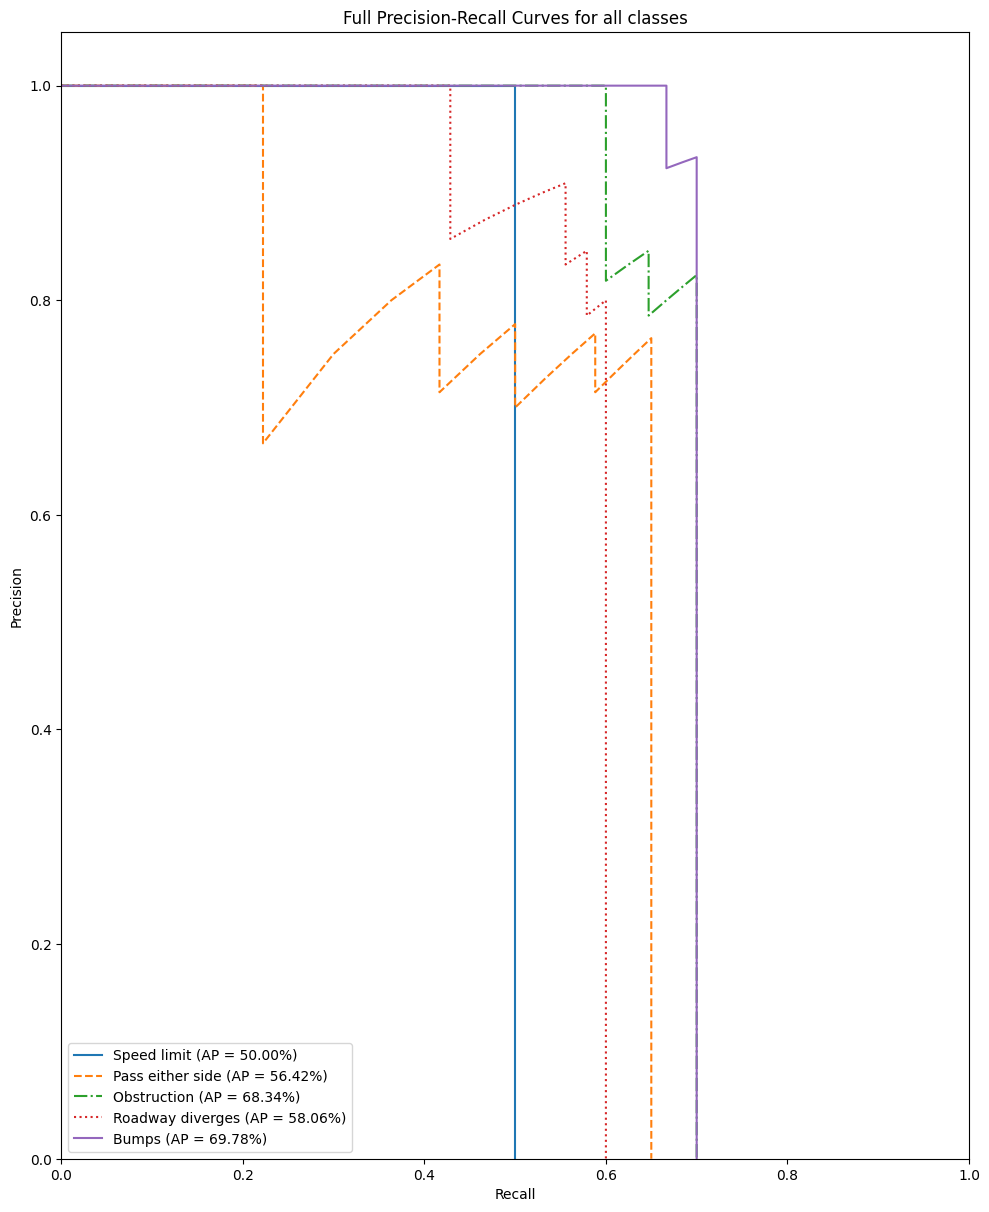

0.6052042662141005

<Figure size 640x480 with 0 Axes>

In [22]:
# Compute the evaluation metrics
compute_mean_average_precision(detections)

## Plot detections

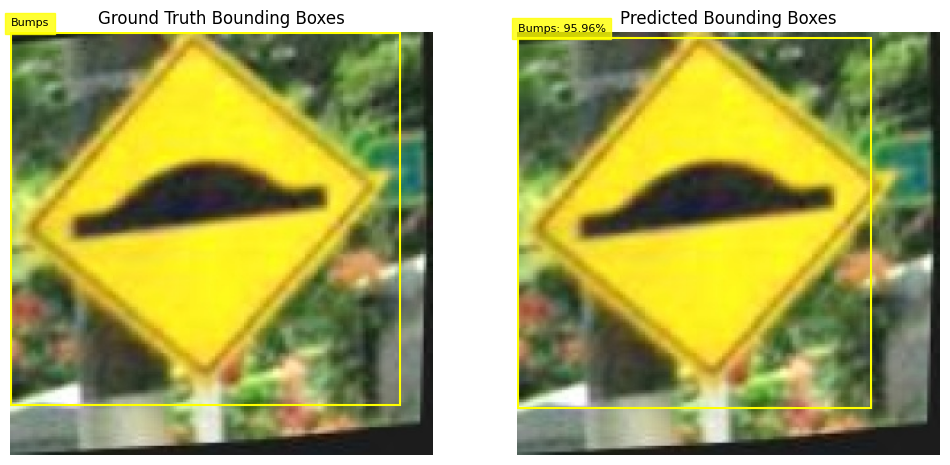

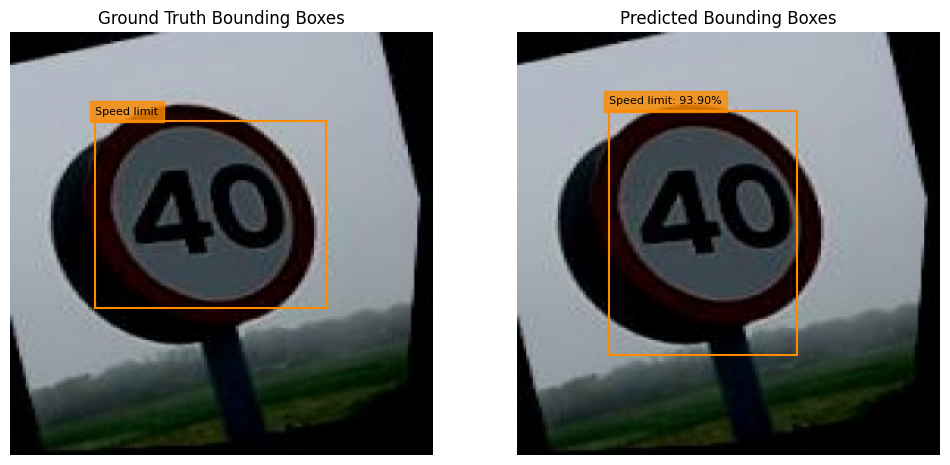

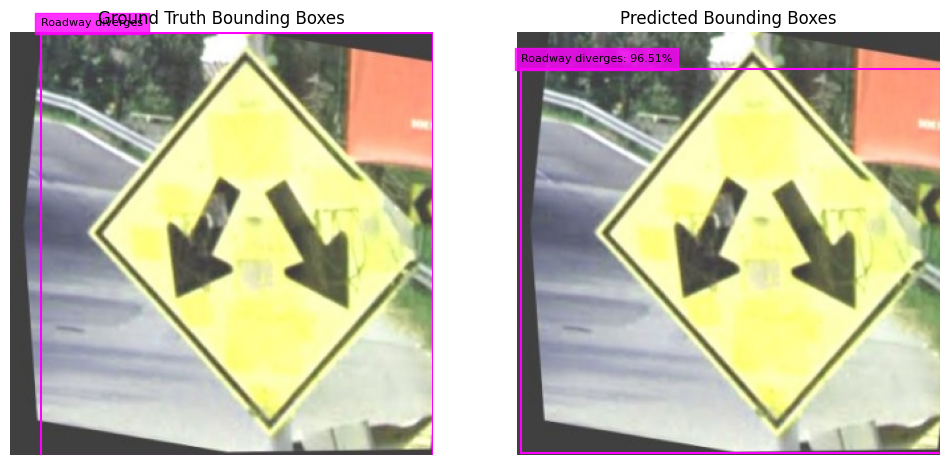

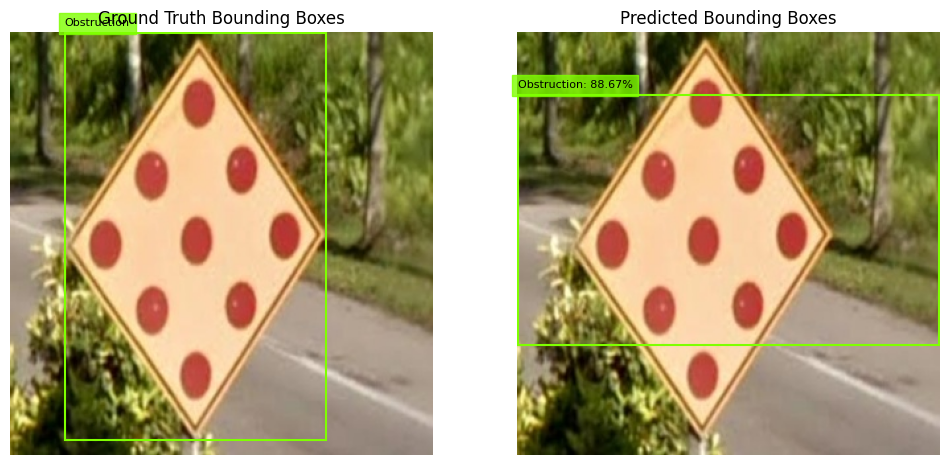

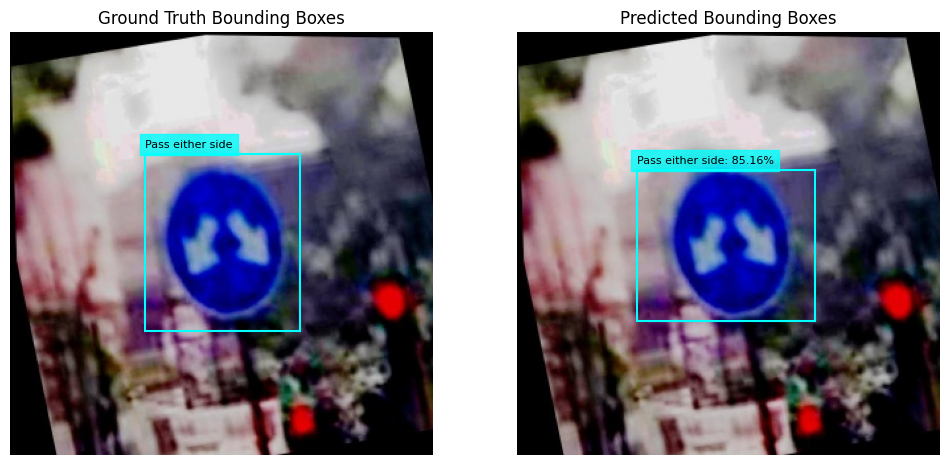

In [23]:
filename = ['189_png.rf.c3662824dcc13e2ea5b9b06b912960c0.jpg', 'SPEED_LIM-31-_jpg.rf.8fdf7ead6d4cb0e209c620720041924a.jpg', '07_PNG.rf.252f2513a4b26003901cc4bf4ba09f0d.jpg', 'Obstruction-448-_PNG.rf.280e2c32cc038994d8bd7acf5ce9ad19.jpg', 'perintah-pilihan-memasuki-salah-satu-jalur-52-_jpg.rf.c381aa0954a9699fc24fe78a89d41a6d.jpg']

for file in filename:
    sample = get_detection_by_filename(detections, file)
    plot_dets(sample, file)